## GoingDeeperCv <br/> - 6. CAM을 만들고 평가해 보자

#### 데이터셋 준비

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터셋을 다운로드.
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

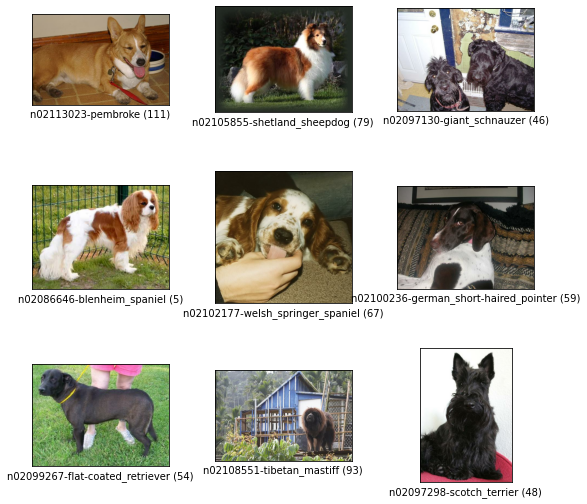

Figure(648x648)


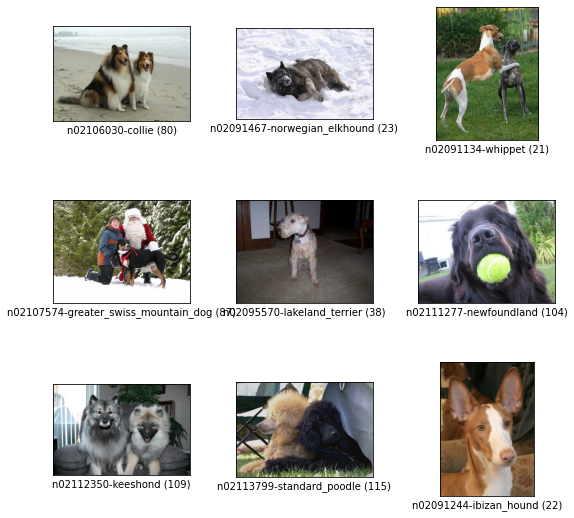

Figure(648x648)


In [4]:
# tfds.show_examples() 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인.
print(tfds.show_examples(ds_train, ds_info))
print('='*75)
# 학습용 데이터셋 뿐만 아니라 평가용 데이터셋도 눈으로 확인.
print(tfds.show_examples(ds_test, ds_info))

#### 물체의 위치정보

In [5]:
# df_info를 조회해 features가 어떻게 구성되어 있는지 확인.
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


- `image`, `label`은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스.
- `bbox`는 물체의 위치를 사각형 영역으로 표기하는 방법. `BBoxFeature`이라는 타입으로 정의

#### 바운딩 박스를 표시하는 방법
- 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법
- **xywh**
        
        바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법.
        ex. (x_center, y_center, width, height)
        x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있다.

- **minmax**
        
        바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법.
        ex. (x_min, x_max, y_min, y_max)
        좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 
        normalize한 상대적인 값을 표기하는 것이 일반적.

## CAM

#### CAM 구현

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False, # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg', # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

- 마지막 fully connected layer 대신 GAP을 사용. 
<br/> ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 쉽게 GAP 연산 가능.

In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

#### 모델 학습

In [8]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [10]:
tf.random.set_seed(2705)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [11]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 369s 457ms/step - loss: 3.2243 - accuracy: 0.2796 - val_loss: 3.7695 - val_accuracy: 0.1471
Epoch 2/15
750/750 [==============================] - 331s 441ms/step - loss: 0.9412 - accuracy: 0.7366 - val_loss: 1.4071 - val_accuracy: 0.6065
Epoch 3/15
750/750 [==============================] - 331s 441ms/step - loss: 0.3507 - accuracy: 0.9135 - val_loss: 1.0346 - val_accuracy: 0.6992
Epoch 4/15
750/750 [==============================] - 331s 441ms/step - loss: 0.0968 - accuracy: 0.9887 - val_loss: 0.9035 - val_accuracy: 0.7338
Epoch 5/15
750/750 [==============================] - 331s 441ms/step - loss: 0.0314 - accuracy: 0.9987 - val_loss: 0.9506 - val_accuracy: 0.7353
Epoch 6/15
750/750 [==============================] - 331s 442ms/step - loss: 0.0369 - accuracy: 0.9976 - val_loss: 0.9422 - val_accuracy: 0.7365
Epoch 7/15
750/750 [==============================] - 331s 441ms/step - loss: 0.0163 - accuracy: 0.9997 - val_loss: 0.9337 -

In [13]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/cv/g6/cam_1012_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


#### CAM

In [17]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [18]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

- CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에
<br/> `get_one()` 함수로 데이터셋에서 한장씩 뽑을 수 있도록 함.

67


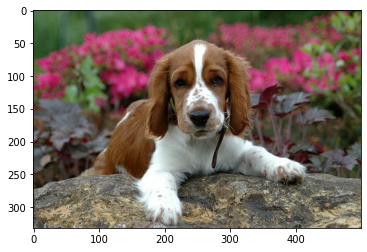

In [19]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [21]:
!pwd

/aiffel/aiffel/cv/g6


In [22]:
# CAM을 생성하기 위해 이전 스텝에서 학습한 모델을 불러옴.
import os
cam_model_path = os.getenv('HOME')+'/aiffel/cv/g6/cam_1012_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

- CAM을 생성하기 위해서는 <br/> 1. 특성 맵, 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 원하는 클래스의 출력값이 필요.
- 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 <br/> 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화 한다.


- 이를 고려해서 `model`과 `item`을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수 제작.

- `generate_cam()` 을 구현하기 위해 아래에서는 
<br/> `conv_ouputs`와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, 
<br/> feedforward를 거친 후 CAM을 계산하도록 구현. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 `resize`함

In [23]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

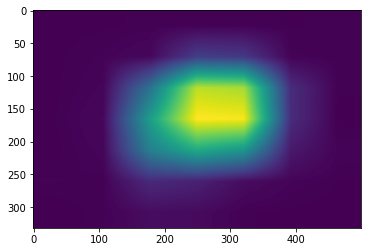

In [24]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [26]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

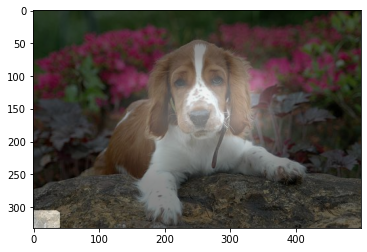

In [27]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

- 주로 강아지의 얼굴과 몸통이 있는 부분이 강조되는 경향이 있는데, <br/> 이것은 사람이 개를 식별할 때 유의해서 보는 부분과 비슷하다. 그런것 같다.

## Grad CAM

- `grad_cam`은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, <br/> 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구함.
- 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 <br/> 레이어에서 나온 채널별 특성 맵을 가중합해주어 `cam_image`를 얻음.

84


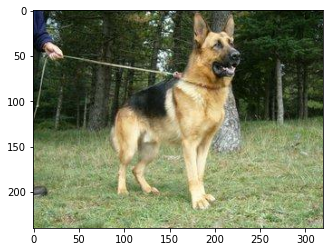

In [30]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- `generate_grad_cam()`에서는 원하는 레이어의 `output`과 <br/> 특정 클래스의 prediction 사이의 그래디언트 `grad_val`을 얻고 이를 `weights`로 활용.

In [32]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

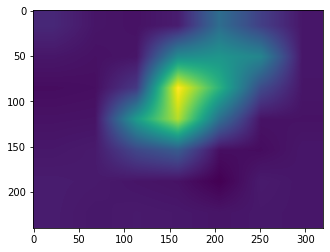

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

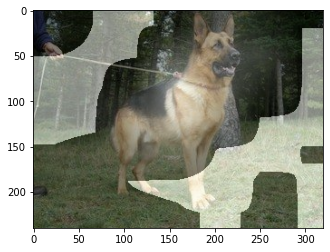

In [35]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

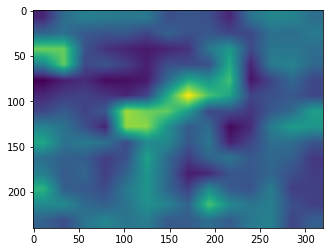

In [36]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

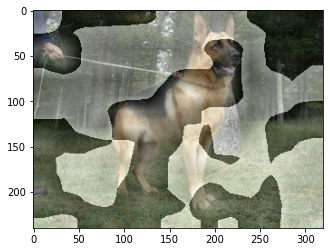

In [37]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

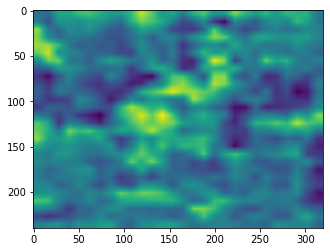

In [38]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

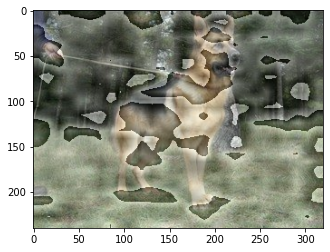

In [39]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Detection with CAM

#### 바운딩 박스
     CAM에서 물체의 위치를 찾는 detection

84


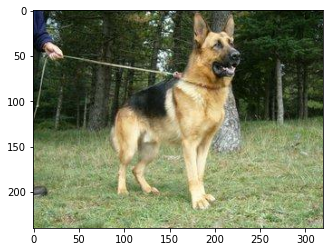

In [42]:
# bbox from CAM
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

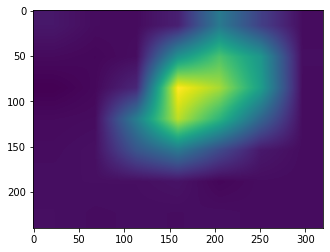

In [43]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

- `get_bbox()` 함수는 바운딩 박스를 만들기 위해서 `score_thresh` 를 받아 
<br/> 역치값 이하의 바운딩 박스는 제거.
- OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 서치. 
<br/> 이때 `rotated_rect` 라는 회전된 바운딩 박스를 얻는다. 
<br/> `boxPoints()`로 이를 꼭지점으로 변경. 마지막에는 int 자료형으로 변환.

In [44]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh # 역치값 이하의 바운딩 박스는 제거.
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt) # 회전된 바운딩 박스를 얻는다.
    rect = cv2.boxPoints(rotated_rect) # 꼭지점으로 변경
    rect = np.int0(rect) # int 자료형으로 변환
    return rect

In [45]:
rect = get_bbox(cam_image)
rect

array([[ 74,   0],
       [292,   0],
       [292, 185],
       [ 74, 185]])

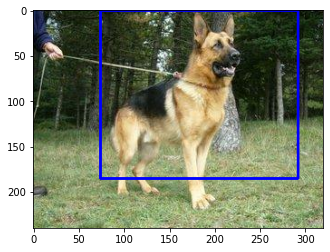

In [46]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

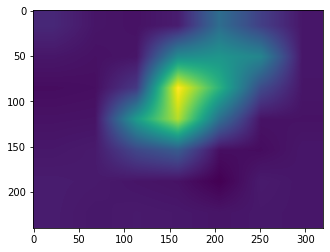

In [50]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [51]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[ 38, 104],
       [232, -55],
       [326,  58],
       [131, 218]])

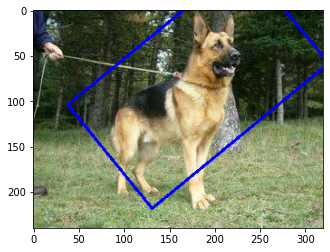

In [52]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

#### Intersection Over Union
    두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값.
    
    찾고자 하는 물건의 절대적인 면적과 상관없이, 
    영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 
    모델이 영역을 잘 찾았는지 비교하는 좋은 지표.

In [47]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [56]:
# CAM bbox
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.23125, 0.7708333333333334, 0.9125]

In [57]:
# Grad-CAM bbox
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[-0.22916666666666666, 0.11875, 0.9083333333333333, 1.01875]

In [61]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [67]:
# CAM IoU
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6399999936655407

In [68]:
# Grad-CAM IoU
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.4400484431590862

## 회고

#### 결과
- CAM은 강아지의 넓은 범위를 특징으로 잡고 추출했으며
<br/> Grad_CAM은 비교적 머리를 포함한 상체 위주로 특징을 잡아 추출했다.


- CAM의 바운딩 박스가 상대적으로 더 넓은 범위를 특징으로 잡고 추출 하기에 
<br/> IoU값은 Grad_CAM(0.44)보다 CAM(0.63)이 약 0.2 정도 높게 나왔다.

#### 느낀 점
- 다른 고딥에 비해서 상대적으로 괜찮았던 노드였다.
- G4보단 모델 학습 시간이 4분의 1수준이라 맘에 들었다....